In [6]:
import pickle
features = pickle.load(open('NDA_NOPAD_MFCC&PitchOnly.p',"rb"))

In [7]:
import pandas as pd
columns = ["name","features","emotion"]
features = pd.DataFrame(data = features, columns = columns)

Ricordiamo anche in questo modulo la distribuzione del dataset

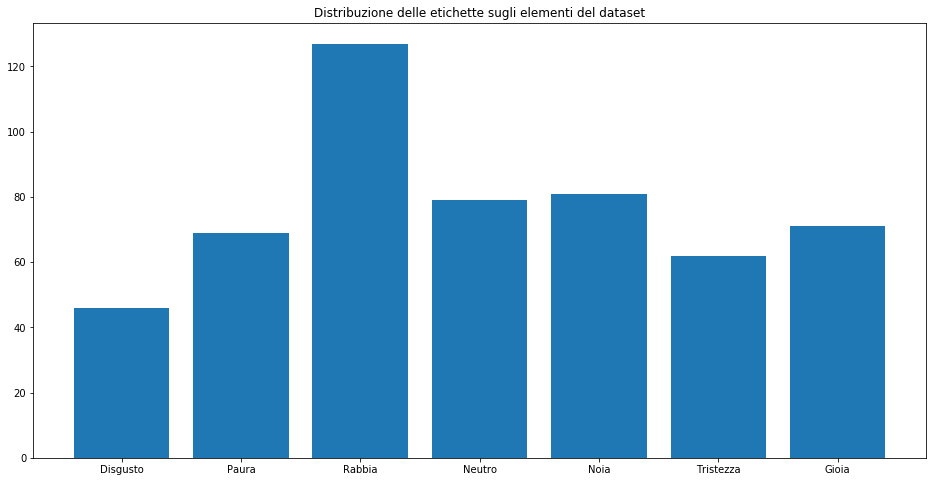

In [10]:
%matplotlib inline

labels = set(features['emotion'])
count = [[label,list(features['emotion']).count(label)] for label in labels]
dict_count = dict(count)

import matplotlib.pyplot as plt

fig = plt.gcf()
plt.title("Distribuzione delle etichette sugli elementi del dataset"), fig.set_size_inches(16, 8)
plt.bar(range(len(dict_count)), dict_count.values()), plt.xticks(range(len(dict_count)), dict_count.keys())
plt.show()

Definiamo la funzione per associare un vettore in cui l'elemento i-esimo = 1 sse i è l'indice dell'emozione indicata dal label.
Tale funzione è necessaria perché l'output della rete neurale sarà un vettore con una misura di probabilità per ogni emozione.

In [11]:
import sklearn.preprocessing as prep
import numpy as np
Emotions = {"Rabbia": 0, "Noia": 1, "Disgusto": 2, "Paura": 3, "Gioia": 4, "Tristezza": 5, "Neutro": 6}
def one_hot_encode(labels):
    n_labels= len(labels)
    labelt = []
    for l in labels:
        labelt.append(Emotions[l])
    n_unique_labels = len(np.unique(labelt))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labelt] = 1
    return one_hot_encode

def numberEncode(labels):
    n_labels= len(labels)
    labelt = []
    for l in labels:
        labelt.append(Emotions[l])
    return labelt

Suddividiamo il dataset per fare la cross-validation.

In [12]:
#-----------------IL seguente blocco di codice serve a gestire la data augmentation-----------------------
# from sklearn.model_selection import KFold
# import numpy as np

# yLong = features['emotion']
# xLong = features.drop(['name','emotion'], 1)

# featuresShort= features.iloc[::3]
# y = featuresShort['emotion']
# x = featuresShort.drop(['name','emotion'], 1)

# nsplits= 10
# kf = KFold(nsplits, shuffle = True, random_state = 3)
# folds = kf.split(x,y)

# train_data=[]
# train_label=[]
# test_data=[]
# test_label=[]
# for f in folds:
#     train = f[0]*3
#     for i in train:
#         train= np.append(train,i+1)
#         train= np.append(train,i+2)
#     train = np.sort(train)
#     test = f[1]*3
#     train_data.append(np.array(list(xLong.iloc[train]['features'])))
#     train_label.append(np.array(list(yLong.iloc[train])))
#     test_data.append(np.array(list(xLong.iloc[test]['features'])))
#     test_label.append(np.array(list(yLong.iloc[test])))

from sklearn.model_selection import KFold
import numpy as np

y = features['emotion']
x = features.drop(['name','emotion'], 1)

nsplits= 10
kf = KFold(nsplits, shuffle = True, random_state = 3)
folds = kf.split(x,y)

train_data=[]
train_label=[]
test_data=[]
test_label=[]
for f in folds:
    train_data.append(np.array(list(x.iloc[f[0]]['features'])))
    train_label.append(one_hot_encode(np.array(list(y.iloc[f[0]]))))
    test_data.append(np.array(list(x.iloc[f[1]]['features'])))
    test_label.append(one_hot_encode(np.array(list(y.iloc[f[1]]))))

Verifichiamo che le dimensioni siano corrette

In [13]:
trainsize = len(train_data[0]);
testsize= len(test_data[0]);
print ("Dimensione dei fold di train: " + str(len(train_data[0])) + " elementi")
print ("Dimensione dei fold di test: " + str(len(test_data[0])) + " elementi")

Dimensione dei fold di train: 481 elementi
Dimensione dei fold di test: 54 elementi


Settiamo i parametri della rete, definendo una funzione che copre tutta la gestione di quest'ultima. Così ci risulta estremamente comodo testarla con vari parametri, in particolare il numero di neuroni

In [16]:
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support
def nn_run(training_epochs,dim_one,dim_three,f):
    #parametri principali
    n_dim =155 #dimensione delle feature
    n_classes = 7
    n_hidden_units_one = dim_one
    n_hidden_units_three = dim_three
    sd = 1 / np.sqrt(n_dim)
    learning_rate = 0.001
    
    #input layer
    X = tf.placeholder(tf.float32,[None,n_dim])
    
    #per le etichette reali, così da confrontarle con l'output della rete
    Y = tf.placeholder(tf.float32,[None,n_classes])
    
    #per la funzione di drop-off
    keep_prob = tf.placeholder(tf.float32)

    #primo hidden layer
    W_1 = tf.Variable(tf.random_normal([n_dim,n_hidden_units_one], mean = 0, stddev=sd))
    b_1 = tf.Variable(tf.random_normal([n_hidden_units_one], mean = 0, stddev=sd))
    h_1 = tf.nn.relu(tf.matmul(X,W_1) + b_1)

    #secondo hidden layer
    W_3 = tf.Variable(tf.random_normal([n_hidden_units_one,n_hidden_units_three], mean = 0, stddev=sd))
    b_3 = tf.Variable(tf.random_normal([n_hidden_units_three], mean = 0, stddev=sd))
    h_3 = tf.nn.relu(tf.matmul(h_1,W_3) + b_3)

    drop_out = tf.nn.dropout(h_3, keep_prob)
    
    #output layer
    W = tf.Variable(tf.random_normal([n_hidden_units_three,n_classes], mean = 0, stddev=sd))
    b = tf.Variable(tf.random_normal([n_classes], mean = 0, stddev=sd))
    y_ = tf.nn.softmax(tf.matmul(drop_out,W) + b) 
    
    #calcolo della cross-entropia ed passo di discesa del gradiente
    cost_function = tf.reduce_mean(-tf.reduce_sum(Y*tf.log(tf.clip_by_value(y_,1e-11,1.0))))
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost_function)

    #calcolo dell'accuratezza
    correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    #inizializzazione delle variabili
    init = tf.global_variables_initializer()
    
    #allocazione array per memorizzare i vari parametri in output: 
    #il costo, ovvero la funzione di perdita
    cost_history = np.empty(shape=[1],dtype=float)
    #accuratezza
    acc_history = np.empty(shape=[1],dtype=float)
    
    
    #eseguiamo tensorflow con l'ausilio della GPU
    with tf.device('/gpu:0'):
        #prepariamo l'esecuzione della rete
        with tf.Session() as sess:
            sess.run(init)
            
            #esecuzione della rete nelle varie epoche
            for epoch in range(training_epochs):
                
                #la rete viene feedata con un insieme random di elementi
                index = int(np.random.uniform(0,trainsize,1))
                batch_size = 13 # Divisore del mio trainsize
                
                #addestramento della rete
                _,cost = sess.run([optimizer,cost_function],feed_dict={X:train_data[f][index:index+batch_size, :],
                                                               Y:train_label[f][index:index+batch_size, :], keep_prob : 0.5})
                #memorizzazione valori in output
                cost_history = np.append(cost_history,cost)
                acc_history = np.append(acc_history,round(sess.run(accuracy, feed_dict={X:test_data[f], Y:test_label[f], keep_prob : 1.0}),3))

    return max(acc_history[1:])

Definiamo le funzioni per eseguire la rete. 
In particolare anche la gestione della cross-validation, che, seppur onerosa, è necessaria per offrire dei risultati affidabili.
Quello che segue è un esempio di run, i risultati migliori si trovano sull'omonimo file .html consegnato

In [19]:
def setParamandRun(epochs,layer1,layer2):
    #eseguito nsplits di volte la rete neurale per la cross-validation.
    maxacc=[]
    for i in range(nsplits):
        maxacc= np.append(maxacc,nn_run(epochs,layer1,layer2,i))
    print (np.mean(maxacc))
    return maxacc

for i in range(130,160,10):
    print(setParamandRun(5000,i,i))

0.8803999960422516
[0.852      0.852      0.94400001 0.87       0.889      0.86799997
 0.90600002 0.86799997 0.88700002 0.86799997]
0.8726999998092652
[0.852      0.852      0.94400001 0.87       0.90700001 0.88700002
 0.90600002 0.792      0.84899998 0.86799997]
0.8801999986171722
[0.889      0.833      0.963      0.87       0.87       0.84899998
 0.94300002 0.82999998 0.86799997 0.88700002]
